# Dask Array

Материалы:
* Макрушин С.В. Лекция 11: Dask
* https://docs.dask.org/en/latest/array.html
* JESSE C. DANIEL. Data Science with Python and Dask. 

## Задачи для совместного разбора

1. Создайте массив размерностью 1000 на 300000, заполненный числами из стандартного нормального распределения. Исследуйте основные характеристики полученного массива.

2. Посчитайте сумму квадратов элементов массива, созданного в задаче 1. Создайте массив `np.array` такого же размера и сравните скорость решения задачи с использование `da.array` и `np.array`

3. Визуализируйте граф вычислений для задачи 12.

## Лабораторная работа 11

In [2]:
import dask.array as da
import h5py
import numpy as np
import sys

1. Считайте датасет `recipe` из файла `minutes_n_ingredients_full.hdf5` в виде `dask.array`. Укажите аргумент `chunks=(100_000, 3)` при создании массива. Выведите на экран основную информацию о массиве.

In [3]:
recipe_f = h5py.File('minutes_n_ingredients_full.hdf5')['recipe']
recipe = da.from_array(recipe_f, chunks=(100000, 3))
recipe

dask.array<array, shape=(2231637, 3), dtype=int64, chunksize=(100000, 3), chunktype=numpy.ndarray>

2. Вычислите среднее значение по каждому столбцу, кроме первого. 

In [14]:
%%timeit
mean_values = recipe[:, 1:].mean(axis=0)
mean_values.compute()

46.6 ms ± 147 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
print(mean_values.compute())

[1004.20805176    5.4198008 ]


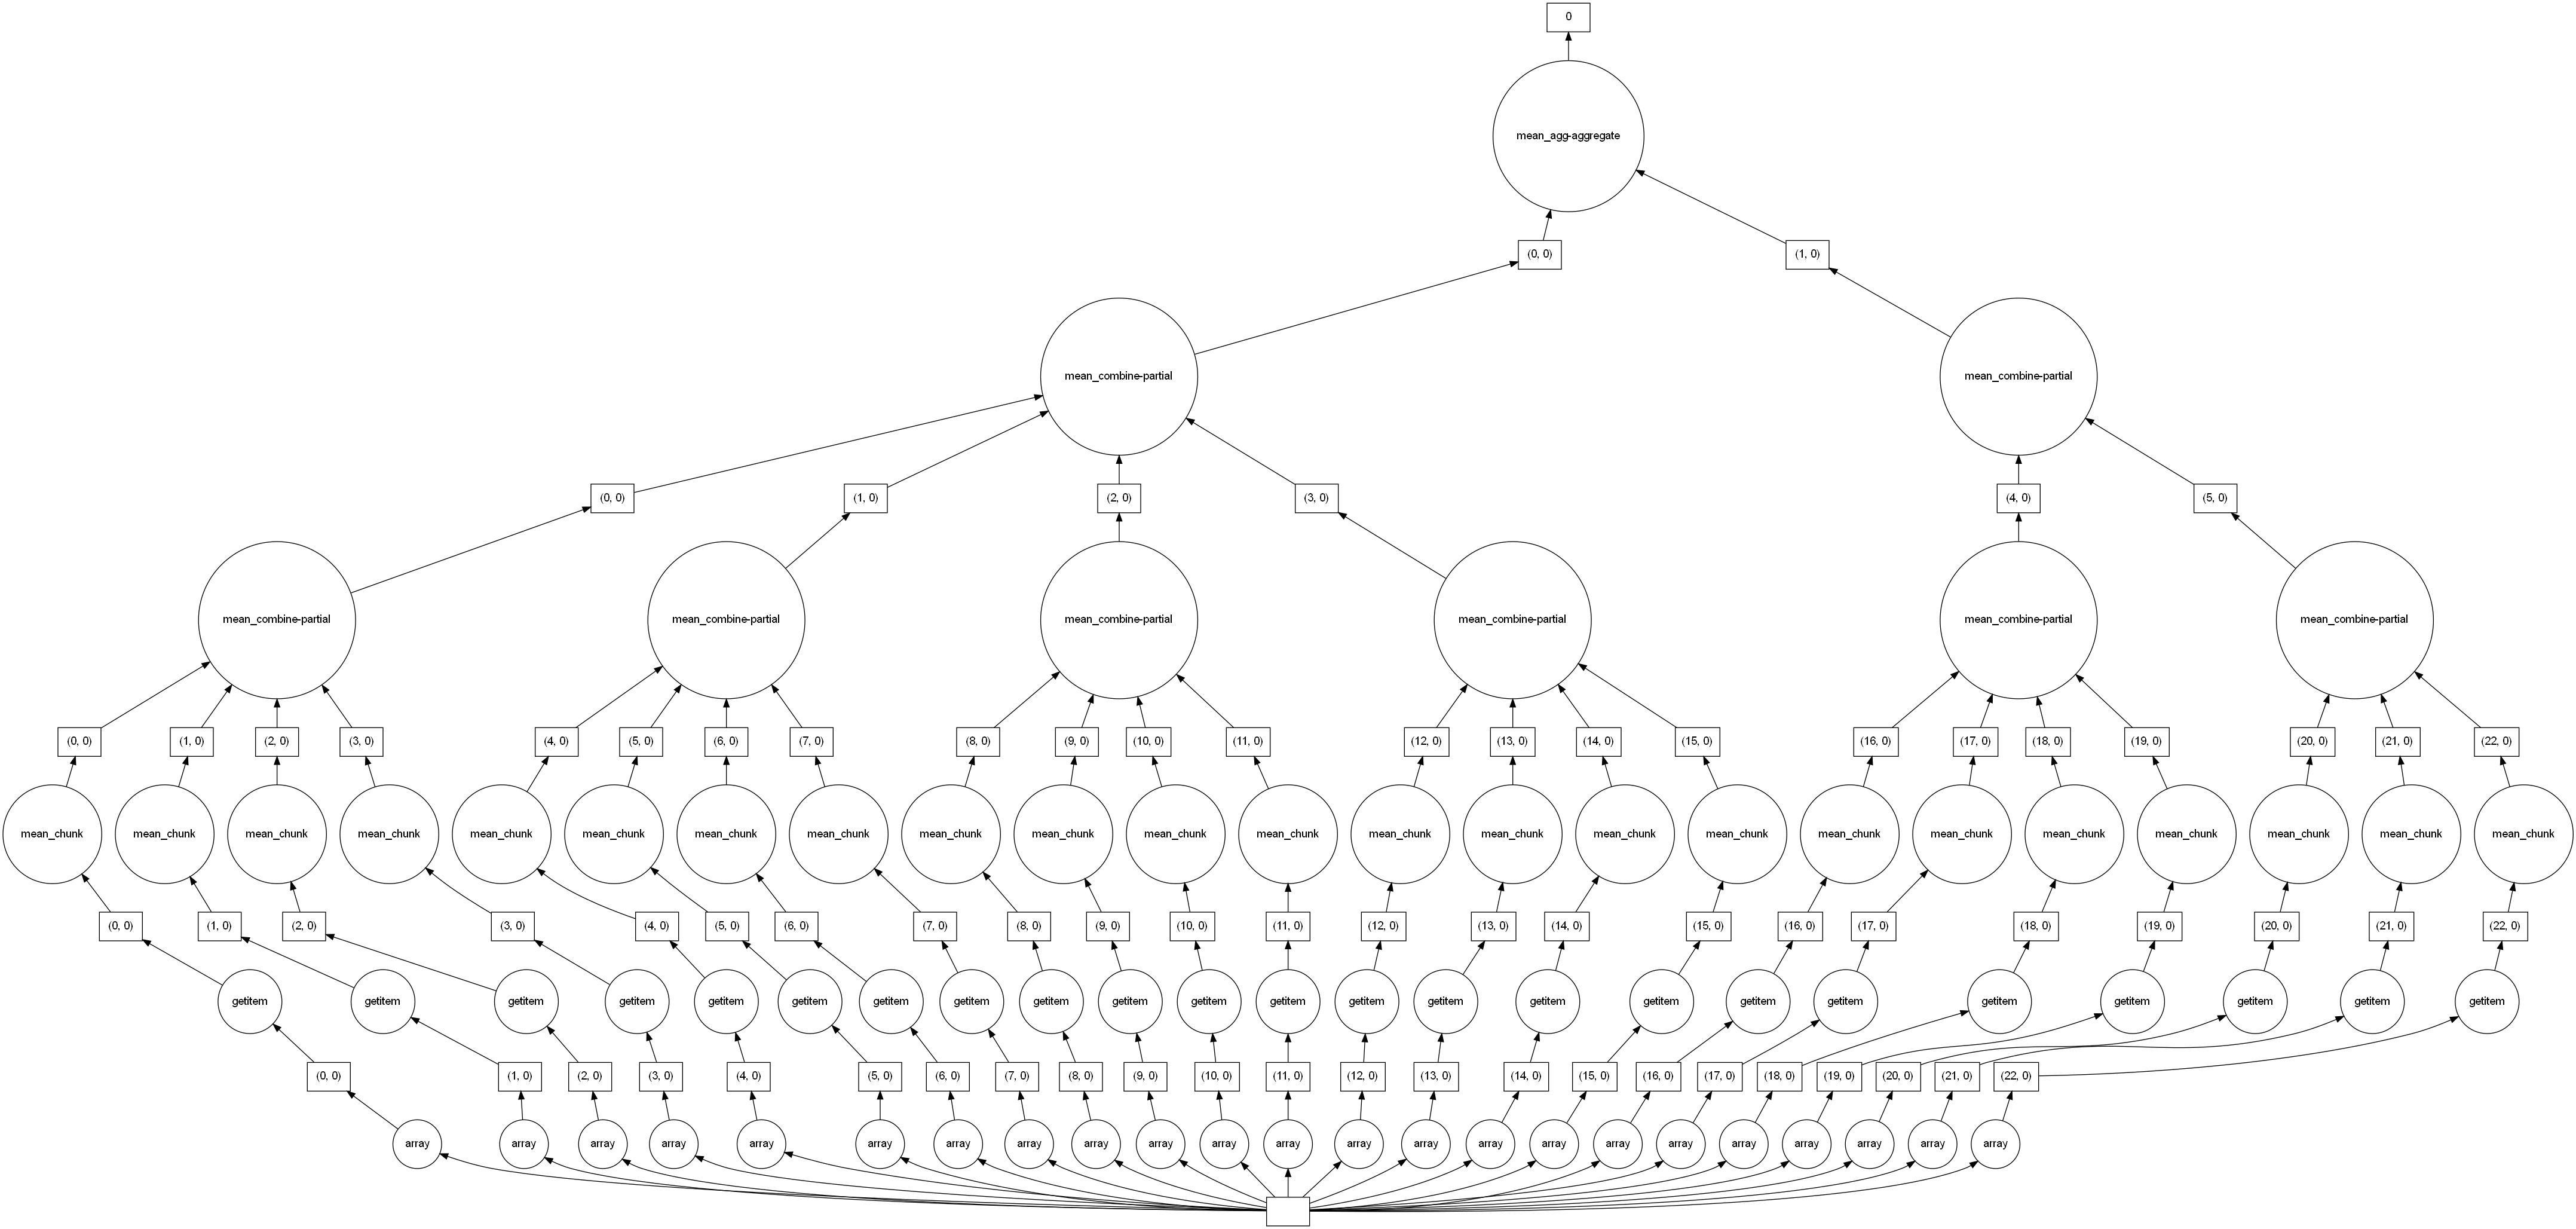

In [12]:
mean_values.visualize()

3. Исследуйте, как влияет значение аргумента `chunks` при создании `dask.array` на скорость выполнения операции поиска среднего. 

In [1]:
import time

In [4]:
test_array1 = da.from_array(recipe_f, chunks=(10, 3))
test_array2 = da.from_array(recipe_f, chunks=(100, 3))
test_array3 = da.from_array(recipe_f, chunks=(1000, 3))
test_array4 = da.from_array(recipe_f, chunks=(10000, 3))
test_array5 = da.from_array(recipe_f, chunks=(1000000, 3))

In [5]:
start = time.time()
mean_values1 = test_array1[:, 1:].mean(axis=0)
a1 = mean_values1.compute()
print(time.time() - start)
a1

129.24162006378174


array([1004.20805176,    5.4198008 ])

In [6]:
start = time.time()
mean_values2 = test_array2[:, 1:].mean(axis=0)
a2 = mean_values2.compute()
print(time.time() - start)
a2

12.1993989944458


array([1004.20805176,    5.4198008 ])

In [7]:
start = time.time()
mean_values3 = test_array3[:, 1:].mean(axis=0)
a3 = mean_values3.compute()
print(time.time() - start)
a3

1.220123291015625


array([1004.20805176,    5.4198008 ])

In [8]:
start = time.time()
mean_values4 = test_array4[:, 1:].mean(axis=0)
a4 = mean_values4.compute()
print(time.time() - start)
a4

0.1311185359954834


array([1004.20805176,    5.4198008 ])

In [15]:
start = time.time()
mean_values5 = test_array5[:, 1:].mean(axis=0)
a5 = mean_values5.compute()
print(time.time() - start)
a5

0.055057525634765625


array([1004.20805176,    5.4198008 ])

### Получаем, что, чем больше чанк, тем быстрее подсчитывается среднее значение по столбцам

4. Выберите рецепты, время выполнения которых меньше медианного значения

In [22]:
med = da.median(recipe[:, 1], axis=0).compute()
print(med)
recipe[recipe[:, 1] < med].compute()

32.0


array([[1089012,      23,       5],
       [1428572,       0,       5],
       [1400250,      24,       1],
       ...,
       [1029131,      19,       4],
       [1700703,       1,       1],
       [ 713836,       0,       9]], dtype=int64)

5. Посчитайте количество каждого из возможных значений кол-ва ингредиентов

In [34]:
values, counts = da.unique(recipe[:, 2], return_counts=True)
values = values.compute()
counts = counts.compute()
for i in range(len(values)):
    print(values[i], counts[i])

1 222071
2 224158
3 229388
4 234948
5 240720
6 244360
7 247181
8 246747
9 246816
10 22430
11 19094
12 15165
13 11640
14 8284
15 6014
16 4145
17 2793
18 1913
19 1279
20 852
21 529
22 346
23 244
24 178
25 107
26 68
27 55
28 33
29 22
30 20
31 13
32 5
33 4
34 3
35 4
36 1
37 2
38 1
39 1
40 2
43 1


6. Найдите максимальную продолжительность рецепта. Ограничьте максимальную продолжительность рецептов сверху значением, равному 75% квантилю.

In [41]:
max_val = da.max(recipe[:, 1]).compute()
print(f"Максимальное значение длительности рецепта: {max_val}")
quantile = 0.75
max_val_q = recipe.to_dask_dataframe()[1].quantile(quantile).compute()
print(f"Максимальное значение длительности рецепта, ограниченное 75% квантилем: {max_val_q}")

Максимальное значение длительности рецепта: 2147483647
Максимальное значение длительности рецепта, ограниченное 75% квантилем: 49.0


7. Создайте массив `dask.array` из 2 чисел, содержащих ваши предпочтения относительно времени выполнения рецепта и кол-ва ингредиентов. Найдите наиболее похожий (в смысле $L_1$) рецепт из имеющихся в датасете.

In [55]:
mins = 15
ingredients = 6
new_arr = da.from_array([mins, ingredients])
razn = new_arr - recipe[:, 1:] # Массив разностей между моим запросом и исходными данными
num = da.fabs(razn).sum(axis=1).argmin().compute()
print(num)
recipe[num].compute()

20


array([1132618,      15,       6], dtype=int64)

8. Работая с исходным файлом в формате `hdf5`, реализуйте алгоритм подсчета среднего значения в блочной форме и вычислите с его помощью среднее значение второго столбца в массиве.

Блочный алгоритм вычислений состоит из двух частей:
1. Загрузка фрагмента за фрагментом данных по `blocksize` элементов и проведение вычислений на этим фрагментом
2. Агрегация результатов вычислений на различных фрагментах для получения результата на уровне всего набора данных

Важно: при работе с `h5py` в память загружаются не все элементы, а только те, которые запрашиваются в данный момент

In [3]:
%%timeit
filename = "minutes_n_ingredients_full.hdf5"
dataset_name = "recipe"

blocksize = 10000 # размер блока

with h5py.File(filename, 'r') as file:
    dataset = file[dataset_name]
    n = dataset.shape[0]   # количество элементов в массиве
    sum_column_2 = 0.0     # сумма второго столбца
    count_column_2 = 0     # количество элементов во втором столбце
    i = 0                  # индекс первого элемента текущего блока
    while i < n:
        j = min(i + blocksize, n)                   # индекс последнего элемента текущего блока
        data_block = dataset[i:j]                   # загрузка блока данных в память
        sum_column_2_block = data_block[:, 1].sum() # вычисление суммы второго столбца в текущем блоке
        sum_column_2 += sum_column_2_block          # обновление общей суммы второго столбца
        count_column_2 += j - i                     # обновление общего количества элементов во втором столбце
        i = j                                       # переход к следующему блоку
    avg_column_2 = sum_column_2 / count_column_2    # вычисление среднего значения второго столбца
f"Среднее значение второго столбца: {avg_column_2}"

12.6 ms ± 1.9 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [73]:
f"Среднее значение второго столбца: {avg_column_2}"

'Среднее значение второго столбца: 1004.2080517575215'